In [32]:
!pip install -U scikit-multiflow

     |████████████████████████████████| 16.3MB 4.0MB/s 


In [0]:
%matplotlib notebook

[0 1]
accuracy for test number 1  is: 65
auc for test number 1  is: 80.82415340677275
accuracy for test number 2  is: 85
auc for test number 2  is: 90.14020805065581
accuracy for test number 3  is: 79
auc for test number 3  is: 84.79120879120879
accuracy for test number 4  is: 73
auc for test number 4  is: 82.8125
accuracy for test number 5  is: 75
auc for test number 5  is: 84.46519524617997
accuracy for test number 6  is: 84
auc for test number 6  is: 85.65365025466895
accuracy for test number 7  is: 75
auc for test number 7  is: 83.91265597147951
accuracy for test number 8  is: 82
auc for test number 8  is: 89.37132519222071
accuracy for test number 9  is: 88
auc for test number 9  is: 93.62745098039217
accuracy for test number 10  is: 83
auc for test number 10  is: 87.41215378255477
accuracy for test number 11  is: 82
auc for test number 11  is: 88.28282828282829
accuracy for test number 12  is: 85
auc for test number 12  is: 89.10590277777779
accuracy for test number 13  is: 87
au

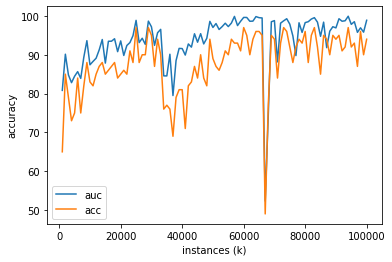

In [33]:
import numpy as np
from skmultiflow.data import AGRAWALGenerator
from skmultiflow.data import HyperplaneGenerator
from skmultiflow.trees.hoeffding_tree import HoeffdingTree
from sklearn.metrics import roc_auc_score


class REDI:

    def __init__(self, stream, number_of_targets, data_block_size=500, num_of_dynamic_classifiers=10,
                 selection_ratio=0.25, stream_length=10000, sudden_drift=False, drift_point=2000, test_point=1000, test_size=100):
        self.classes = np.arange(number_of_targets)
        print(self.classes)

        # params
        self.num_of_classes = number_of_targets
        self.data_block_size = data_block_size
        self.num_of_dynamic_classifiers = num_of_dynamic_classifiers
        self.selection_ratio = selection_ratio
        self.stream_length = stream_length
        self.stream = stream

        # extra initializing
        self.dynamic_classifiers_weights = np.ones(num_of_dynamic_classifiers) / float(num_of_dynamic_classifiers)
        self.static_classifier_weight = 0.5
        self.dynamic_classifiers = []
        for i in range(num_of_dynamic_classifiers):
            self.dynamic_classifiers.append(None)
        self.dcir_values = {}
        for classe in self.classes:
            self.dcir_values[classe] = 0
        self.dynamic_classifiers_dcir = []
        for i in range(num_of_dynamic_classifiers):
            dcir_classifier_values = {}
            for classe in self.classes:
                dcir_classifier_values[classe] = 0
            self.dynamic_classifiers_dcir.append(dcir_classifier_values)
        self.static_classifier = None

        # Procedure initializing
        self.dc_indicator = 0
        self.cc_array = [None] * data_block_size
        self.resampling_buffer = {}
        for classe in self.classes:
            self.resampling_buffer[classe] = []

        # evaluation paramters
        self.test_batch_size = test_size
        self.test_point = test_point
        self.accuracies = []
        self.aucs = []

        self.drift_point = drift_point
        self.sudden_drift = sudden_drift

    def create_new_base_classifier(self):
        r_n = self.cc_array[-int(self.selection_ratio * self.data_block_size):]
        h_n = {}
        h_d = {}
        buffer_data = {}
        for classe in self.classes:
            buffer_data[classe] = []
        x_train = []
        y_train = []
        for classe in self.classes:
            h_n[classe] = 0
            h_d[classe] = 0
            buffer_data[classe] = []
        for i in range(len(r_n)):
            x_i = r_n[i]
            self.reinforcement_weight_adjustment(x_i)
            h_n[x_i[1][0]] += 1
            h_d[x_i[1][0]] += 1
            buffer_data[x_i[1][0]].append(x_i)
        classifier = HoeffdingTree()
        balanced_size = int(self.selection_ratio * self.data_block_size / self.num_of_classes)
        for classe in self.classes:
            if h_n[classe] < balanced_size:
                extra_length = balanced_size - h_n[classe]
                if len(self.resampling_buffer[classe]) < extra_length:
                    extra_data = self.resampling_buffer[classe]
                else:
                    extra_data = self.resampling_buffer[classe][-extra_length:]
                h_d[classe] += len(extra_data)
                for row in extra_data:
                    x = row[0][0]
                    y = row[1][0]
                    x_train.append(x)
                    y_train.append(y)
        for row in r_n:
            x = row[0][0]
            y = row[1][0]
            x_train.append(x)
            y_train.append(y)
        X_train = np.array(x_train)
        Y_train = np.array(y_train)
        classifier.partial_fit(X_train, Y_train, self.classes)
        dynamic_classifiers_dcir = {}
        for classe in self.classes:
            dynamic_classifiers_dcir[classe] = h_d[classe]
        for classe in self.classes:
            self.resampling_buffer[classe].extend(buffer_data[classe])
            self.resampling_buffer[classe] = self.resampling_buffer[classe][-balanced_size:]
        return classifier, dynamic_classifiers_dcir

    def dcir(self):
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        dcir = {}
        tot = 0
        for classe in self.classes:
            val = 0
            for i in range(number_of_current_classifiers):
                val += self.dynamic_classifiers_dcir[i][classe] * self.dynamic_classifiers_weights[i]
            dcir[classe] = val
            tot += val
        for classe in self.classes:
            dcir[classe] /= tot
        self.dcir_values = dcir

    def shift_classifiers(self, dynamic_classifier, dcir_d_v):
        for i in range(self.num_of_dynamic_classifiers - 1):
            self.dynamic_classifiers[i] = self.dynamic_classifiers[i + 1]
            self.dynamic_classifiers_dcir[i] = self.dynamic_classifiers_dcir[i + 1]
            self.dynamic_classifiers_weights[i] = self.dynamic_classifiers_weights[i + 1]
        classifier_index = min(self.num_of_dynamic_classifiers, self.dc_indicator) - 1
        self.dynamic_classifiers_weights[classifier_index] = 1 / float(self.num_of_dynamic_classifiers)
        self.dynamic_classifiers_dcir[classifier_index] = dcir_d_v
        self.dynamic_classifiers[classifier_index] = dynamic_classifier

    def train_on_instance(self, x_new, cc_current_position):
        x_i = self.cc_array[cc_current_position]
        self.reinforcement_weight_adjustment(x_i)
        x = x_i[0]
        y = x_i[1]
        self.static_classifier.partial_fit(x, y, self.classes)
        for i in range(self.num_of_dynamic_classifiers):
            if self.dynamic_classifiers[i] is not None:
                self.dynamic_classifiers[i].partial_fit(x, y, self.classes)
                self.dynamic_classifiers_dcir[i][y[0]] += 1
        self.cc_array[cc_current_position] = x_new

    def update_classifiers_weights(self):
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        for i in range(number_of_current_classifiers):
            self.dynamic_classifiers_weights[i] *= (
                    1 - 1 / float(min(self.num_of_dynamic_classifiers, self.dc_indicator)))

    def reinforcement_weight_adjustment(self, x_i):
        x = x_i[0]
        y = x_i[1][0]
        flag = True
        for classe in self.classes:
            flag = flag and self.dcir_values[classe] == 0
        if flag:
            return
        if self.dcir_values[y] < 1 / float(self.num_of_classes):
            for i in range(self.num_of_dynamic_classifiers):
                if self.dynamic_classifiers[i] is not None:
                    if self.dynamic_classifiers[i].predict(x)[0] == y:
                        self.dynamic_classifiers_weights[i] *= (
                                1 + 1 / float(self.num_of_dynamic_classifiers))
                    else:
                        self.dynamic_classifiers_weights[i] *= (
                                1 - 1 / float(self.num_of_dynamic_classifiers))
            if self.static_classifier is not None:
                if self.static_classifier.predict(x)[0] == y:
                    self.static_classifier_weight *= (
                            1 + 1 / float(self.num_of_dynamic_classifiers))
                else:
                    self.static_classifier_weight *= (
                            1 - 1 / float(self.num_of_dynamic_classifiers))

    def normalize_weights(self):
        classifiers_number = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        total_weight = self.static_classifier_weight
        for i in range(classifiers_number):
            total_weight += self.dynamic_classifiers_weights[i]
        self.static_classifier_weight = self.static_classifier_weight / float(total_weight)
        for i in range(classifiers_number):
            self.dynamic_classifiers_weights[i] = self.dynamic_classifiers_weights[i] / float(total_weight)

    def learning_procedure(self):
        processes_counter = 0
        for index in range(self.stream_length):
            x_new = self.stream.next_sample()
            processes_counter += 1
            if processes_counter % self.drift_point == 0 and processes_counter >= self.drift_point:
                if self.sudden_drift:
                    stream.generate_drift()
            if processes_counter > self.data_block_size and processes_counter % self.test_point == 1:
                self.normalize_weights()
                test_set = self.stream.next_sample(self.test_batch_size)
                self.evaluate_batch(test_set)
            if processes_counter < self.data_block_size:
                self.cc_array[processes_counter - 1] = x_new
            elif processes_counter == self.data_block_size:
                self.cc_array[processes_counter - 1] = x_new
                self.static_classifier, _ = self.create_new_base_classifier()
                self.dc_indicator = 1
                self.dynamic_classifiers[self.dc_indicator - 1] = self.static_classifier
            else:
                cc_current_position = (processes_counter - 1) % self.data_block_size
                self.train_on_instance(x_new, cc_current_position)
                cc_current_position = (cc_current_position + 1) % self.data_block_size
                if cc_current_position == 0:
                    self.dc_indicator += 1
                    dynamic_classifier, dcir_d_v = self.create_new_base_classifier()
                    if self.dc_indicator <= self.num_of_dynamic_classifiers:
                        self.dynamic_classifiers[self.dc_indicator - 1] = dynamic_classifier
                        self.dynamic_classifiers_dcir[self.dc_indicator - 1] = dcir_d_v
                    else:
                        self.shift_classifiers(dynamic_classifier, dcir_d_v)
                    self.update_classifiers_weights()
                    self.dcir()
        for i in range(self.data_block_size):
            x_new = self.cc_array[i]
            self.train_on_instance(x_new, i)

    def predict(self, test_set):
        test_set_array = test_set[0]
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        predict_prop = self.static_classifier.predict_proba(test_set_array) * self.static_classifier_weight
        for i in range(number_of_current_classifiers):
            predict_prop += self.dynamic_classifiers[i].predict_proba(test_set_array) * \
                            self.dynamic_classifiers_weights[i]
        res = np.argmax(predict_prop, axis=1)
        props = np.amax(predict_prop,axis=1)
        return res, props

    def evaluate_batch(self, test_set):
        res, prop = self.predict(test_set)
        for i in range(len(res)):
            if res[i] == 0:
                prop[i] = 1- prop[i]
        real_val = test_set[1]
        accuracy = ((res == real_val) * 1).sum()
        auc = roc_auc_score(real_val, prop) * 100
        self.accuracies.append(accuracy)
        self.aucs.append(auc)
        print("accuracy for test number", len(self.accuracies), " is:", accuracy)
        print("auc for test number", len(self.accuracies), " is:", auc)


stream = AGRAWALGenerator(classification_function=5, random_state=112, balance_classes=False)
# stream = HyperplaneGenerator()
number_of_targets = 2
stream.prepare_for_use()
classifier = REDI(stream, number_of_targets, stream_length=100002, sudden_drift=True, drift_point=33335)
classifier.learning_procedure()
from matplotlib import pyplot as plt
inds = np.arange(1000,100001,1000)
plt.plot(inds, classifier.aucs)
plt.plot(inds, classifier.accuracies)
plt.xlabel("instances (k)")
plt.ylabel("accuracy")
plt.legend(('auc', 'acc'), loc='lower left')
plt.show()

In [0]:
import numpy as np
import pandas as pd

from skmultiflow.trees.hoeffding_tree import HoeffdingTree


class REDI:

    def __init__(self, data_stream_file, target, data_block_size=500, num_of_dynamic_classifiers=10,
                 selection_ratio=0.25):
        df = pd.read_csv(data_stream_file)
        print("Number of instances is: ", len(df))
        self.real_classes = np.array(df[target].unique())
        print(self.real_classes)
        self.classes = np.arange(len(self.real_classes))
        print("Number of classes is: ", len(self.real_classes))
        self.classes_mask = {}
        for i in range(len(self.classes)):
            self.classes_mask[self.real_classes[i]] = i
        df[target] = df.apply(lambda x: self.classes_mask[x[target]], axis=1)
        self.target = target
        self.df = df
        # params
        df = pd.read_csv(data_stream_file)
        self.num_of_classes = len(self.classes)
        self.data_block_size = data_block_size
        self.num_of_dynamic_classifiers = num_of_dynamic_classifiers
        self.selection_ratio = selection_ratio

        # extra initializing
        self.dynamic_classifiers_weights = np.ones(num_of_dynamic_classifiers) / float(num_of_dynamic_classifiers)
        self.static_classifier_weight = 0.5
        self.dynamic_classifiers = []
        for i in range(num_of_dynamic_classifiers):
            self.dynamic_classifiers.append(None)
        self.dcir_values = {}
        for classe in self.classes:
            self.dcir_values[classe] = 0
        self.dynamic_classifiers_dcir = []
        for i in range(num_of_dynamic_classifiers):
            dcir_classifier_values = {}
            for classe in self.classes:
                dcir_classifier_values[classe] = 0
            self.dynamic_classifiers_dcir.append(dcir_classifier_values)
        self.static_classifier = None

        # Procedure initializing
        self.dc_indicator = 0
        self.cc_array = [None] * data_block_size
        self.resampling_buffer = {}
        for classe in self.classes:
            self.resampling_buffer[classe] = pd.DataFrame(columns=self.df.columns)

        # evaluation paramters
        self.test_batch_size = 100
        self.test_point = 1000
        self.accuracies = []

    def create_new_base_classifier(self):
        r_n = self.cc_array[-int(self.selection_ratio * self.data_block_size):]
        h_n = {}
        h_d = {}
        buffer_data = {}
        x_train = []
        y_train = []
        for classe in self.classes:
            h_n[classe] = 0
            h_d[classe] = 0
            buffer_data[classe] = []
        for i in range(len(r_n)):
            x_i = r_n[i]
            self.reinforcement_weight_adjustment(x_i)
            h_n[x_i[self.target]] += 1
            h_d[x_i[self.target]] += 1
            buffer_data[x_i[self.target]].append(x_i)
        classifier = HoeffdingTree()
        balanced_size = int(self.selection_ratio * self.data_block_size / self.num_of_classes)
        for classe in self.classes:
            if h_n[classe] < balanced_size:
                extra_length = balanced_size - h_n[classe]
                if len(self.resampling_buffer[classe]) < extra_length:
                    extra_data = self.resampling_buffer[classe]
                else:
                    extra_data = self.resampling_buffer[classe][-extra_length:]
                h_d[classe] += len(extra_data)
                # print("extra data is",extra_data)
                for idx, row in extra_data.iterrows():
                    numpy_row = row.to_numpy()
                    x = numpy_row[:-1]
                    y = numpy_row[-1]
                    x_train.append(x)
                    y_train.append(y)
        for row in r_n:
            numpy_row = row.to_numpy()
            x = numpy_row[:-1]
            y = numpy_row[-1]
            x_train.append(x)
            y_train.append(y)
        classifier.partial_fit(x_train, y_train, self.classes)
        dynamic_classifiers_dcir = {}
        for classe in self.classes:
            dynamic_classifiers_dcir[classe] = h_d[classe]
        for classe in self.classes:
            tmp_df = pd.DataFrame(buffer_data[classe])
            self.resampling_buffer[classe] = self.resampling_buffer[classe].append(tmp_df)
            self.resampling_buffer[classe] = self.resampling_buffer[classe][-balanced_size:]
        return classifier, dynamic_classifiers_dcir

    def dcir(self):
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        dcir = {}
        tot = 0
        for classe in self.classes:
            val = 0
            for i in range(number_of_current_classifiers):
                val += self.dynamic_classifiers_dcir[i][classe] * self.dynamic_classifiers_weights[i]
            dcir[classe] = val
            tot += val
        for classe in self.classes:
            dcir[classe] /= tot
        self.dcir_values = dcir

    def shift_classifiers(self, dynamic_classifier, dcir_d_v):
        for i in range(self.num_of_dynamic_classifiers - 1):
            self.dynamic_classifiers[i] = self.dynamic_classifiers[i + 1]
            self.dynamic_classifiers_dcir[i] = self.dynamic_classifiers_dcir[i + 1]
            self.dynamic_classifiers_weights[i] = self.dynamic_classifiers_weights[i + 1]
        classifier_index = min(self.num_of_dynamic_classifiers, self.dc_indicator) - 1
        self.dynamic_classifiers_weights[classifier_index] = 1 / float(self.num_of_dynamic_classifiers)
        self.dynamic_classifiers_dcir[classifier_index] = dcir_d_v
        self.dynamic_classifiers[classifier_index] = dynamic_classifier

    def train_on_instance(self, x_new, cc_current_position):
        x_i = self.cc_array[cc_current_position]
        self.reinforcement_weight_adjustment(x_i)
        numpy_row = x_i.to_numpy()
        x = [numpy_row[:-1]]
        y = [numpy_row[-1]]
        self.static_classifier.partial_fit(x, y, self.classes)
        for i in range(self.num_of_dynamic_classifiers):
            if self.dynamic_classifiers[i] is not None:
                self.dynamic_classifiers[i].partial_fit(x, y, self.classes)
                self.dynamic_classifiers_dcir[i][y[0]] += 1
        self.cc_array[cc_current_position] = x_new

    def update_classifiers_weights(self):
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        for i in range(number_of_current_classifiers):
            self.dynamic_classifiers_weights[i] *= (
                    1 - 1 / float(min(self.num_of_dynamic_classifiers, self.dc_indicator)))

    def reinforcement_weight_adjustment(self, x_i):
        numpy_row = x_i.to_numpy()
        x = np.array([numpy_row[:-1]])
        y = numpy_row[-1]
        # print("train on instance", x.shape)
        flag = True
        for classe in self.classes:
            flag = flag and self.dcir_values[classe] == 0
        if flag:
            return
        if self.dcir_values[y] < 1 / float(self.num_of_classes):
            for i in range(self.num_of_dynamic_classifiers):
                if self.dynamic_classifiers[i] is not None:
                    if self.dynamic_classifiers[i].predict(x)[0] == y:
                        self.dynamic_classifiers_weights[i] *= (
                                1 + 1 / float(self.num_of_dynamic_classifiers))
                    else:
                        self.dynamic_classifiers_weights[i] *= (
                                1 - 1 / float(self.num_of_dynamic_classifiers))
            if self.static_classifier is not None:
                if self.static_classifier.predict(x)[0] == y:
                    self.static_classifier_weight *= (
                            1 + 1 / float(self.num_of_dynamic_classifiers))
                else:
                    self.static_classifier_weight *= (
                            1 - 1 / float(self.num_of_dynamic_classifiers))

    def normalize_weights(self):
        classifiers_number = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        total_weight = self.static_classifier_weight
        for i in range(classifiers_number):
            total_weight += self.dynamic_classifiers_weights[i]
        self.static_classifier_weight = self.static_classifier_weight / float(total_weight)
        for i in range(classifiers_number):
            self.dynamic_classifiers_weights[i] = self.dynamic_classifiers_weights[i] / float(total_weight)

    def learning_procedure(self):
        # initializing
        processes_counter = 0
        # cc_current_position = 0
        # print(len(self.df))
        # process
        for index, row in self.df.iterrows():
            x_new = row
            processes_counter += 1
            if processes_counter > self.data_block_size and processes_counter % self.test_point == 1:
                self.normalize_weights()
                test_set = self.df[processes_counter:processes_counter + self.test_batch_size]
                self.evaluate_batch(test_set)
            if processes_counter < self.data_block_size:
                self.cc_array[processes_counter - 1] = x_new
            elif processes_counter == self.data_block_size:
                self.cc_array[processes_counter - 1] = x_new
                self.static_classifier, _ = self.create_new_base_classifier()
                self.dc_indicator = 1
                self.dynamic_classifiers[self.dc_indicator - 1] = self.static_classifier
            else:
                cc_current_position = (processes_counter - 1) % self.data_block_size
                self.train_on_instance(x_new, cc_current_position)
                cc_current_position = (cc_current_position + 1) % self.data_block_size
                if cc_current_position == 0:
                    self.dc_indicator += 1
                    dynamic_classifier, dcir_d_v = self.create_new_base_classifier()
                    if self.dc_indicator <= self.num_of_dynamic_classifiers:
                        self.dynamic_classifiers[self.dc_indicator - 1] = dynamic_classifier
                        self.dynamic_classifiers_dcir[self.dc_indicator - 1] = dcir_d_v
                    else:
                        self.shift_classifiers(dynamic_classifier, dcir_d_v)
                    self.update_classifiers_weights()
                    self.dcir()
        for i in range(self.data_block_size):
            x_new = self.cc_array[i]
            self.train_on_instance(x_new, i)

    def predict(self, test_set):
        # print(self.static_classifier_weight)
        test_set = test_set.drop(columns=self.target)
        test_set_array = test_set.to_numpy()
        number_of_current_classifiers = min(self.num_of_dynamic_classifiers, self.dc_indicator)
        predict_prop = self.static_classifier.predict_proba(test_set_array) * self.static_classifier_weight
        for i in range(number_of_current_classifiers):
            predict_prop += self.dynamic_classifiers[i].predict_proba(test_set_array) * \
                            self.dynamic_classifiers_weights[i]
        # print(predict_prop)
        res = np.argmax(predict_prop, axis=1)
        # print(max_props_indices)
        # res = self.classes[max_props_indices]
        # res = self.classes_mask[res]
        return res

    def evaluate_batch(self, test_set):
        res = self.predict(test_set)
        # print(res)
        real_val = test_set[self.target].to_numpy()
        # print(real_val)
        accuracy = ((res == real_val) * 1).sum()
        self.accuracies.append(accuracy)
        print("accuracy for test number", len(self.accuracies), " is:", accuracy)


data_stream_file, target = "covtype.csv", 'Cover_Type'
# data_stream_file, target = 'covtype_mini.csv', 'Cover_Type'
classifier = REDI(data_stream_file, target)
classifier.learning_procedure()
from matplotlib import pyplot as plt
# plt.plot(classifier.accuracies)
inds = np.arange(1000,581012,1000)

plt.plot(inds, classifier.accuracies)
plt.xlabel("instances (k)")
plt.ylabel("accuracy")
plt.show()